In [41]:
from stringprep import b1_set

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from BuilingMLP_Model import X_train
%matplotlib inline

In [42]:
with open('data/names.txt', 'r') as f:
    words = f.read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

Кодировки

In [43]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)

Создание датасета

In [44]:
block_size = 3 # context length

def build_dataset(words):
    # build the dataset
    X, Y = [], []
    for w in words:
        # print(w)
        # Лист болванка из 0 для дальнейшего заполнения
        context = [0] * block_size
        # print(context)
        for ch in w + '.':
            # Индекс символа в словаре
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            # print(''.join(itos[i] for i in context), '------>', itos[ix])
            # Убрали первый символ, добавили новый
            context = context[1:] + [ix] # crop and append
            # print(context)

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [45]:
import random

# Начало случайного распределения зафиксировано, дальше все что будет генерироваться при перезапуске программы будет одинаковым. Если вызывать несколько раз внутри одной и той же программы, результаты будут разными
random.seed(42)

Если seed не задавать, Python использует текущее время или системный источник энтропии

In [46]:
print(random.random())
print(random.random())
print(random.random())

0.6394267984578837
0.025010755222666936
0.27502931836911926


In [47]:
print(random.random())
print(random.random())
print(random.random())

0.22321073814882275
0.7364712141640124
0.6766994874229113


In [48]:
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182570, 3]) torch.Size([182570])
torch.Size([22668, 3]) torch.Size([22668])
torch.Size([22908, 3]) torch.Size([22908])


In [49]:
print(len(words))
print(n1)
print(n2)

32033
25626
28829


Определение MLP

In [50]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


Оптимизационный код

In [51]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activatio
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 25.3636
  10000/ 200000: 2.5778
  20000/ 200000: 2.0606
  30000/ 200000: 2.4627
  40000/ 200000: 2.4529
  50000/ 200000: 2.4948
  60000/ 200000: 2.2895
  70000/ 200000: 2.0816
  80000/ 200000: 2.4105
  90000/ 200000: 2.6047
 100000/ 200000: 2.2398
 110000/ 200000: 1.8785
 120000/ 200000: 2.1691
 130000/ 200000: 2.4880
 140000/ 200000: 1.9370
 150000/ 200000: 2.2358
 160000/ 200000: 1.9472
 170000/ 200000: 1.8916
 180000/ 200000: 1.6782
 190000/ 200000: 2.1456


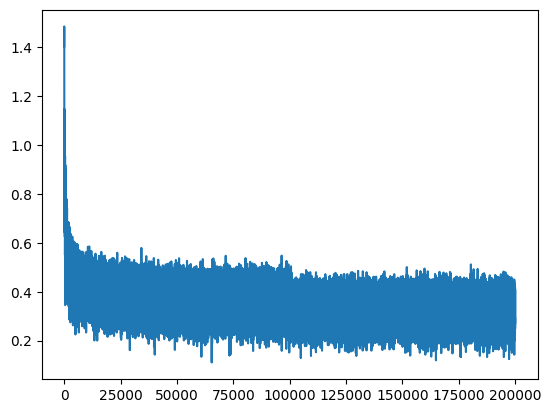

In [52]:
plt.plot(lossi)

In [53]:
# Что бы ни происходило в этой функции, никогда не нужны и не будут применены градиенты
# Все работает быстрее, можно делать через with torch.no_grad...
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtr, Ytr),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1316959857940674
val 2.1766879558563232


In [54]:
g = torch.Generator().manual_seed(42)

for _ in range(20):
    out = []
    context = [0] * block_size # старт с ...
    while True:
        # Контекст на вход, в начале ..., далее заполняется сгенерированными буквами
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        # exps logits
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

anuella.
tis.
marian.
dante.
namillaylen.
kemarce.
man.
emiah.
aden.
dazi.
kenda.
jordin.
kalla.
mikolynn.
ace.
hine.
chanavitharlen.
jayma.
jaconnelari.
kalah.


### Изменяем веса при инициализации

На входе шансы встретить любую букву считаем равными

In [55]:
# Веса
print(torch.tensor(1/27.0))
# Ожидаемая ошибка, тк при случайной инициализации модель случайно сильно уверена в каких-то символах, и отсюда там вылазит сильно бОльшая ошибка
print(-torch.tensor(1/27.0).log())

tensor(0.0370)
tensor(3.2958)


### Тест 1, база

Проводим серию тестов, постепенно изменяя веса при инициализации, смотрим ошибку после первого прогона

In [56]:
def display_model_init_quality(h, hpreact):
    # Сделай одномерным массивом
    plt.hist(h.view(-1).tolist(), 50)
    plt.title('Model Activations')
    plt.show()
    plt.hist(hpreact.view(-1).tolist(), 50)
    plt.title('Model Pre-Activations')
    plt.show()
    plt.figure(figsize=(20, 10))
    plt.imshow(h.abs() > 0.99, cmap='grey', interpolation='nearest')
    plt.title('Almost dead neurons')


In [57]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [58]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activatio
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break


      0/ 200000: 25.3636


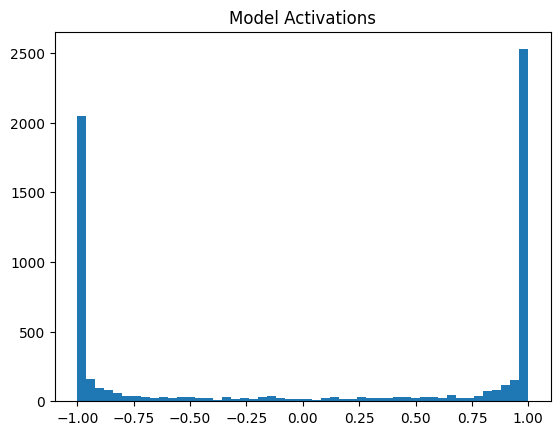

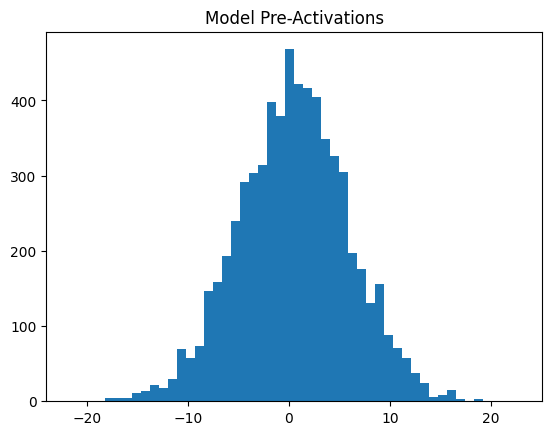

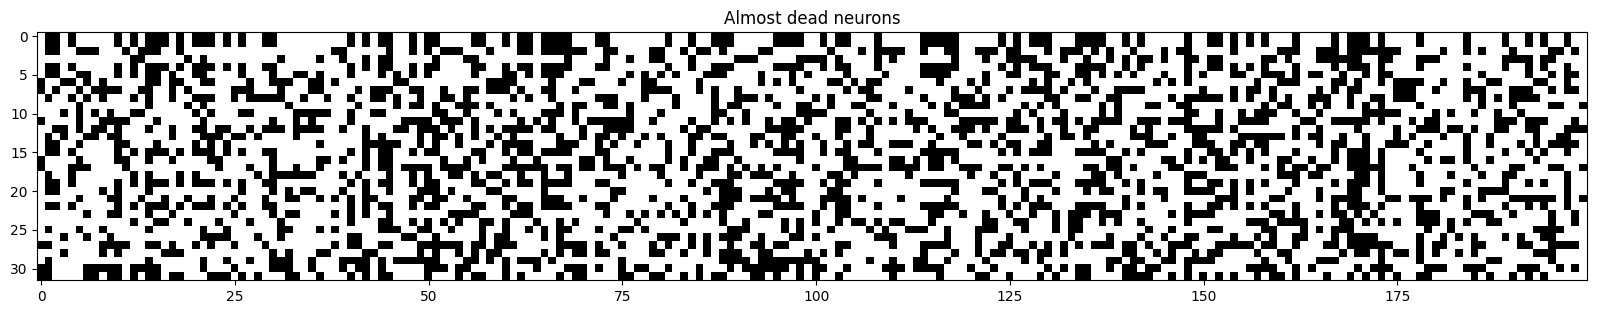

In [59]:
display_model_init_quality(h, hpreact)

In [60]:
logits[0]

tensor([ 12.4119,  -7.6996,   2.3776,   6.5568,  -6.7900, -15.6000, -21.2102,
         -0.6893,  13.2828, -12.5420,  -4.2807,  25.9170,   1.7245, -19.7246,
          2.6588,   7.7760, -15.6614,  14.8147,  16.6351,  -9.3979,  -6.0412,
         -2.7174,  -1.9348,  -4.2945,  -9.4654,  -5.1644,   0.7409],
       grad_fn=<SelectBackward0>)

### Тест 2, зануляю b2, уменьшаю W2, чтобы уменьшить значения первых околослучайных logits

In [61]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


      0/ 200000: 3.3045


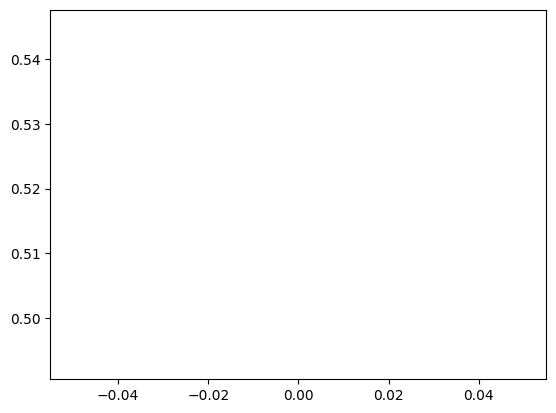

In [62]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activatio
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break
plt.plot(lossi)

In [63]:
h.shape

torch.Size([32, 200])

In [64]:
h

tensor([[-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-0.9993, -0.0673,  0.9300,  ...,  1.0000, -0.8518, -1.0000],
        ...,
        [-1.0000,  0.1622, -1.0000,  ...,  0.9986,  1.0000,  0.9995],
        [ 0.9412, -0.9763,  1.0000,  ..., -0.9986,  0.9842,  1.0000],
        [-0.9092,  0.9366, -1.0000,  ..., -1.0000,  0.9980,  1.0000]],
       grad_fn=<TanhBackward0>)

Смотрим распределение весов

In [65]:
# примеры идут подряд
h.storage()

 -1.0
 0.9603675007820129
 -0.14177054166793823
 0.9999994039535522
 0.8321852087974548
 0.9958342909812927
 0.9982203841209412
 -0.9993781447410583
 -1.0
 -0.9912474155426025
 -0.25999152660369873
 -0.9999021887779236
 0.2740528881549835
 0.9919034838676453
 -0.5112075209617615
 0.858819842338562
 0.9601367712020874
 -0.9989864230155945
 -0.10442907363176346
 0.999836266040802
 -0.9895827174186707
 -0.9797720313072205
 0.9343129992485046
 0.999998927116394
 0.8458945155143738
 0.9940535426139832
 0.8089911937713623
 0.9999799132347107
 -0.9999994039535522
 0.9820908308029175
 -0.3572176992893219
 -0.9999823570251465
 1.0
 0.9993312358856201
 -0.9999996423721313
 -0.9989092946052551
 -0.9962003827095032
 -1.0
 0.9997501969337463
 1.0
 -0.8529655933380127
 -0.9999588131904602
 -0.17352625727653503
 -1.0
 0.9738587737083435
 0.12715953588485718
 -0.9988493919372559
 -0.9999988079071045
 0.4241602122783661
 0.9999991059303284
 -0.9646183848381042
 0.8766809701919556
 0.9999444484710693
 0

(array([2050.,  159.,   94.,   78.,   60.,   35.,   39.,   30.,   24.,
          28.,   22.,   29.,   29.,   22.,   21.,   11.,   32.,   18.,
          24.,   17.,   34.,   39.,   27.,   13.,   13.,   13.,   12.,
          20.,   28.,   13.,   15.,   28.,   23.,   21.,   24.,   28.,
          29.,   24.,   31.,   28.,   24.,   47.,   25.,   27.,   40.,
          76.,   79.,  115.,  156., 2526.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

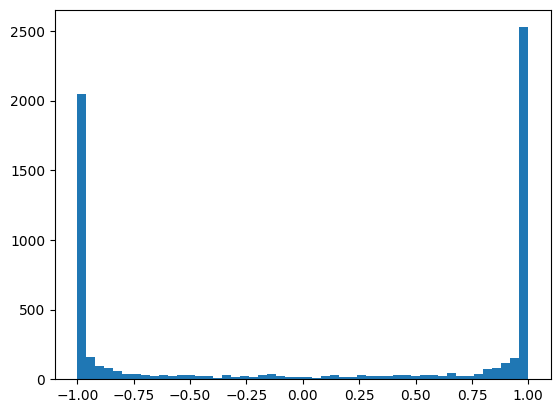

In [66]:
# Сделай одномерным массивом
plt.hist(h.view(-1).tolist(), 50)

tanh все зажаж в диапазон -1 1, и почти все веса близки к этому. Такой график это плохо, тк большая часть весов почти не меняется и не рабочая, мы находимся оч далеко на графике tanh, и почти всеми весами застряли в области малых градиентов

(array([  1.,   0.,   0.,   1.,   5.,   4.,   5.,  11.,  14.,  21.,  17.,
         29.,  69.,  58.,  73., 146., 158., 193., 240., 292., 303., 314.,
        398., 379., 468., 422., 416., 404., 349., 326., 305., 197., 176.,
        131., 156.,  88.,  71.,  58.,  38.,  24.,   6.,   9.,  15.,   3.,
          1.,   3.,   1.,   0.,   1.,   1.]),
 array([-21.82064819, -20.9272599 , -20.03387161, -19.14048332,
        -18.24709503, -17.35370674, -16.46031845, -15.56693016,
        -14.67354187, -13.78015358, -12.88676529, -11.993377  ,
        -11.09998871, -10.20660042,  -9.31321213,  -8.41982384,
         -7.52643555,  -6.63304726,  -5.73965897,  -4.84627068,
         -3.95288239,  -3.05949409,  -2.1661058 ,  -1.27271751,
         -0.37932922,   0.51405907,   1.40744736,   2.30083565,
          3.19422394,   4.08761223,   4.98100052,   5.87438881,
          6.7677771 ,   7.66116539,   8.55455368,   9.44794197,
         10.34133026,  11.23471855,  12.12810684,  13.02149513,
         13.914883

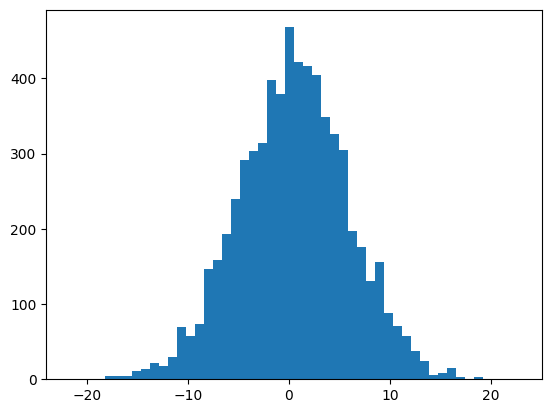

In [67]:
plt.hist(hpreact.view(-1).tolist(), 50)

На вход в tanh шли нормально распределеныые, но большие веса, почему они и стали -1 или 1

Визуализация как посмотреть на кол-во весов ушедших за 0.99

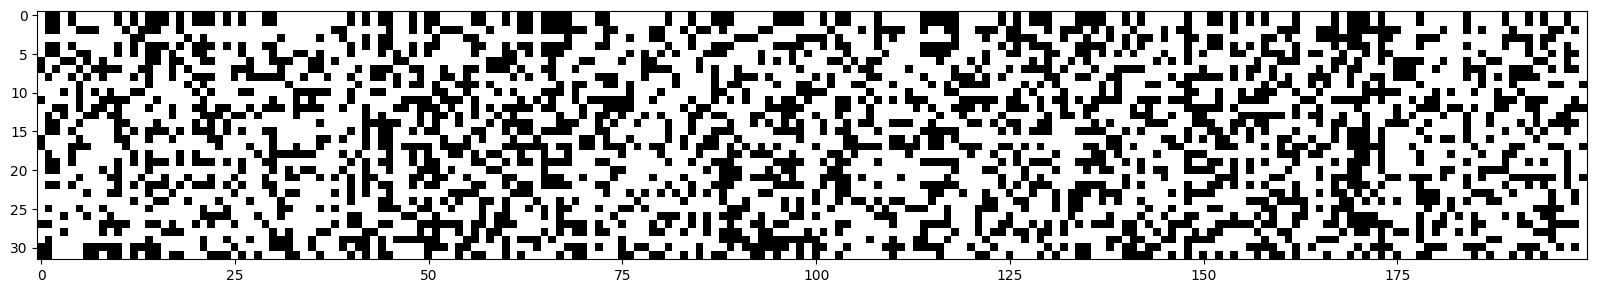

In [68]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='grey', interpolation='nearest')

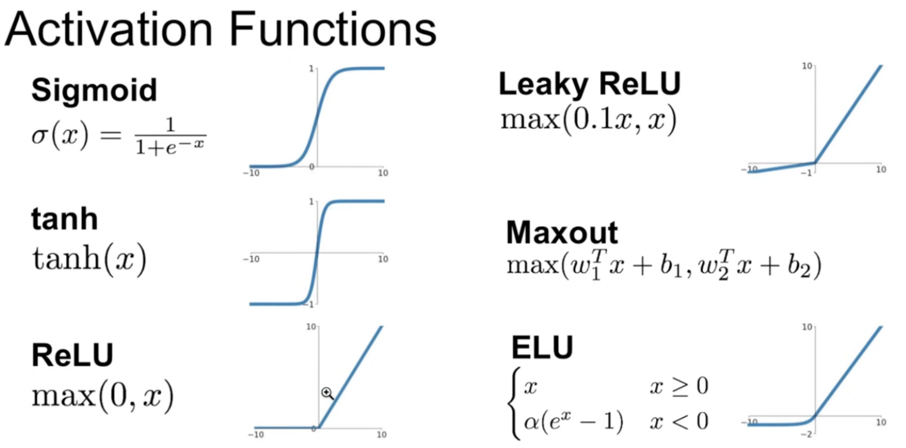

### Тест 3, уменьшаем W1 b1, чтобы убрать показанную проблему на этапе функции активации

In [69]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.01
b1 = torch.randn(n_hidden,                        generator=g) * 0
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


      0/ 200000: 3.2961


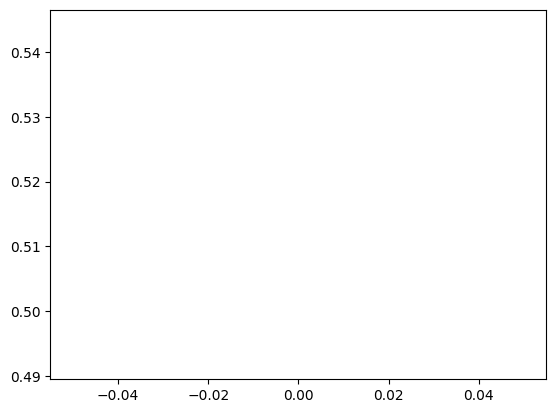

In [70]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activatio
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break
plt.plot(lossi)

In [77]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


      0/ 200000: 3.3037


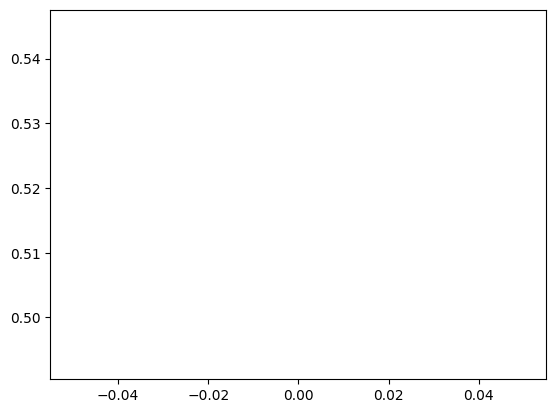

In [78]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activatio
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break
plt.plot(lossi)

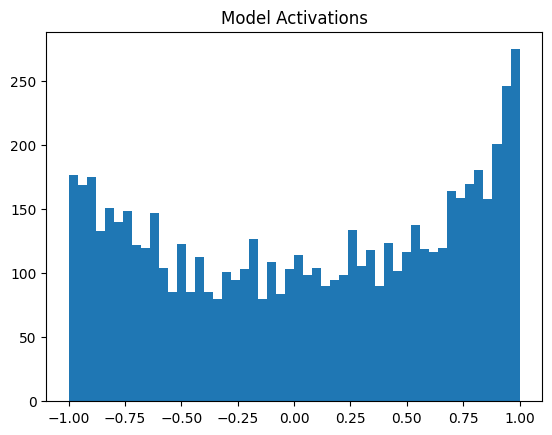

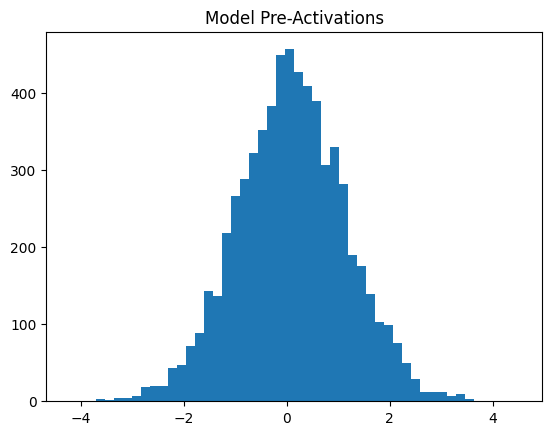

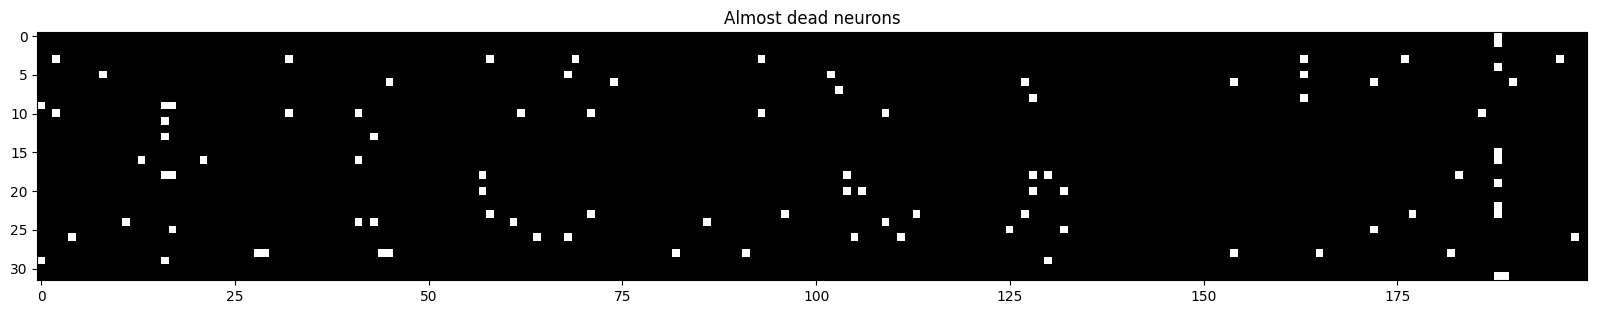

In [79]:
display_model_init_quality(h, hpreact)

Видно что ситуация улучшилась

      0/ 200000: 3.3040
  10000/ 200000: 2.3210
  20000/ 200000: 2.0805
  30000/ 200000: 2.3041
  40000/ 200000: 2.1725
  50000/ 200000: 1.9248
  60000/ 200000: 2.0697
  70000/ 200000: 2.0917
  80000/ 200000: 2.0753
  90000/ 200000: 2.0552
 100000/ 200000: 2.1232
 110000/ 200000: 1.7686
 120000/ 200000: 2.1356
 130000/ 200000: 2.0009
 140000/ 200000: 2.5471
 150000/ 200000: 2.1727
 160000/ 200000: 2.4127
 170000/ 200000: 2.0417
 180000/ 200000: 2.1731
 190000/ 200000: 1.9365


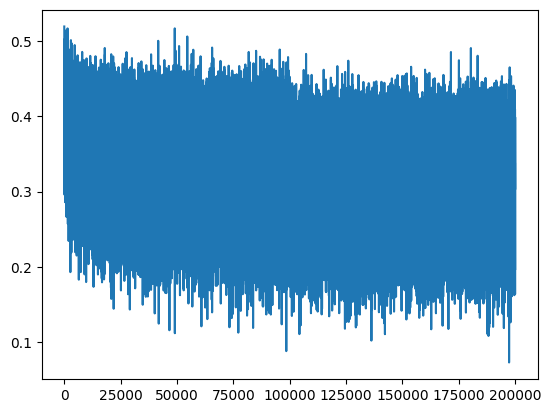

In [80]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activatio
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
plt.plot(lossi)

In [83]:
split_loss('train')
split_loss('val')

train 2.035649538040161
val 2.105647087097168


В случае с такой сеткой даже при отвратительной инициализации она +- чему-то научится, но это не будет работать для более сложных и глубокий сетей 100%

tensor(0.0062) tensor(1.0035)
tensor(0.0033) tensor(3.1611)


(array([5.0000e+00, 5.0000e+00, 5.0000e+00, 1.4000e+01, 2.3000e+01,
        2.1000e+01, 4.9000e+01, 6.9000e+01, 1.3400e+02, 1.9400e+02,
        3.1600e+02, 4.6300e+02, 7.0300e+02, 1.0960e+03, 1.6210e+03,
        2.3860e+03, 3.4040e+03, 4.7280e+03, 6.6260e+03, 8.7880e+03,
        1.1316e+04, 1.3670e+04, 1.5887e+04, 1.7532e+04, 1.8535e+04,
        1.7918e+04, 1.6401e+04, 1.4240e+04, 1.1540e+04, 9.1180e+03,
        7.0020e+03, 5.0140e+03, 3.6210e+03, 2.5510e+03, 1.6970e+03,
        1.1530e+03, 7.4600e+02, 5.3100e+02, 3.3100e+02, 2.0300e+02,
        1.3500e+02, 8.3000e+01, 5.1000e+01, 3.0000e+01, 2.4000e+01,
        9.0000e+00, 5.0000e+00, 2.0000e+00, 2.0000e+00, 3.0000e+00]),
 array([-16.50152779, -15.83011356, -15.15869934, -14.48728512,
        -13.8158709 , -13.14445667, -12.47304245, -11.80162823,
        -11.130214  , -10.45879978,  -9.78738556,  -9.11597134,
         -8.44455711,  -7.77314289,  -7.10172867,  -6.43031445,
         -5.75890022,  -5.087486  ,  -4.41607178,  -3.74465755

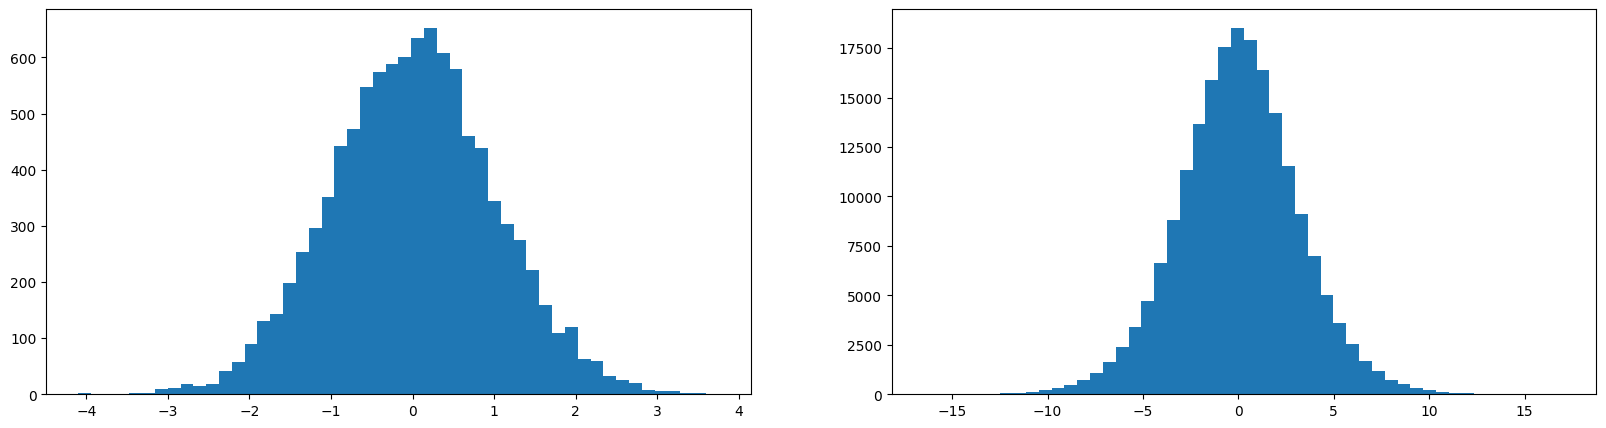

In [92]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)

y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), bins=50)
plt.subplot(1, 2, 2)
plt.hist(y.view(-1).tolist(), bins=50)

Инициализировали W и X, при перемножении среднее итога осталось средним, STD выросло в 3 раза

tensor(0.0110) tensor(1.0057)
tensor(-0.0018) tensor(0.6230)


(array([1.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00, 3.0000e+00,
        7.0000e+00, 1.3000e+01, 1.5000e+01, 3.2000e+01, 5.4000e+01,
        1.0200e+02, 2.0800e+02, 3.1200e+02, 4.9000e+02, 7.9900e+02,
        1.2110e+03, 2.0150e+03, 3.0230e+03, 4.7260e+03, 6.7570e+03,
        9.5600e+03, 1.2603e+04, 1.6159e+04, 1.9139e+04, 2.0628e+04,
        2.0948e+04, 1.9343e+04, 1.6723e+04, 1.3348e+04, 1.0180e+04,
        7.2570e+03, 5.1540e+03, 3.4140e+03, 2.1510e+03, 1.4410e+03,
        8.4200e+02, 5.4400e+02, 3.1700e+02, 1.8800e+02, 1.2200e+02,
        6.1000e+01, 4.8000e+01, 2.4000e+01, 1.6000e+01, 6.0000e+00,
        4.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-3.8151691 , -3.66326076, -3.51135242, -3.35944407, -3.20753573,
        -3.05562739, -2.90371905, -2.75181071, -2.59990237, -2.44799403,
        -2.29608569, -2.14417735, -1.99226901, -1.84036067, -1.68845233,
        -1.53654399, -1.38463565, -1.23272731, -1.08081897, -0.92891063,
        -0.77700229, -0.62

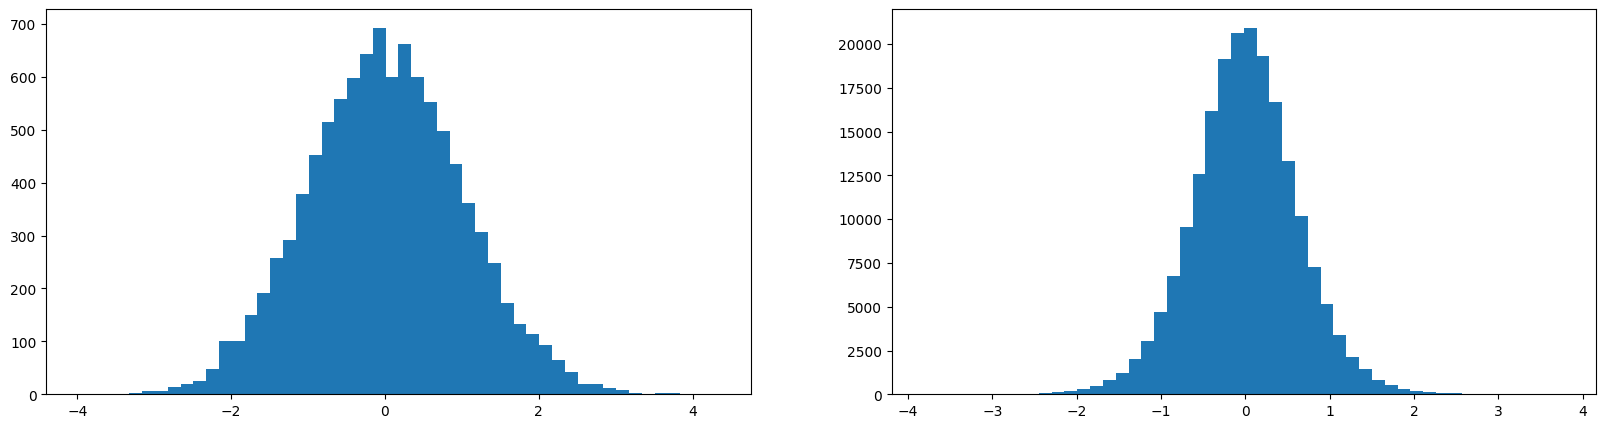

In [93]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 0.2

y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), bins=50)
plt.subplot(1, 2, 2)
plt.hist(y.view(-1).tolist(), bins=50)

При инициализации весов нужно уеньших их так, чтобы после произведения было нормальное стандартное отклонение.

tensor(-0.0020) tensor(0.9994)
tensor(-0.0003) tensor(1.0075)


(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        1.0000e+00, 6.0000e+00, 2.0000e+01, 1.7000e+01, 2.7000e+01,
        5.4000e+01, 1.0200e+02, 1.4700e+02, 2.3800e+02, 3.9400e+02,
        6.2000e+02, 1.0430e+03, 1.6260e+03, 2.4900e+03, 3.6040e+03,
        5.3760e+03, 7.5100e+03, 9.9750e+03, 1.2845e+04, 1.5541e+04,
        1.7916e+04, 1.9051e+04, 1.9347e+04, 1.7960e+04, 1.5706e+04,
        1.3119e+04, 1.0541e+04, 7.9700e+03, 5.4780e+03, 3.8450e+03,
        2.5910e+03, 1.7990e+03, 1.1640e+03, 7.3900e+02, 4.5300e+02,
        2.9200e+02, 1.6700e+02, 9.1000e+01, 5.6000e+01, 3.2000e+01,
        1.7000e+01, 1.0000e+01, 8.0000e+00, 3.0000e+00, 5.0000e+00]),
 array([-6.20284224, -5.97378766, -5.74473309, -5.51567851, -5.28662394,
        -5.05756936, -4.82851479, -4.59946021, -4.37040564, -4.14135106,
        -3.91229649, -3.68324191, -3.45418734, -3.22513276, -2.99607819,
        -2.76702361, -2.53796904, -2.30891446, -2.07985989, -1.85080531,
        -1.62175074, -1.39

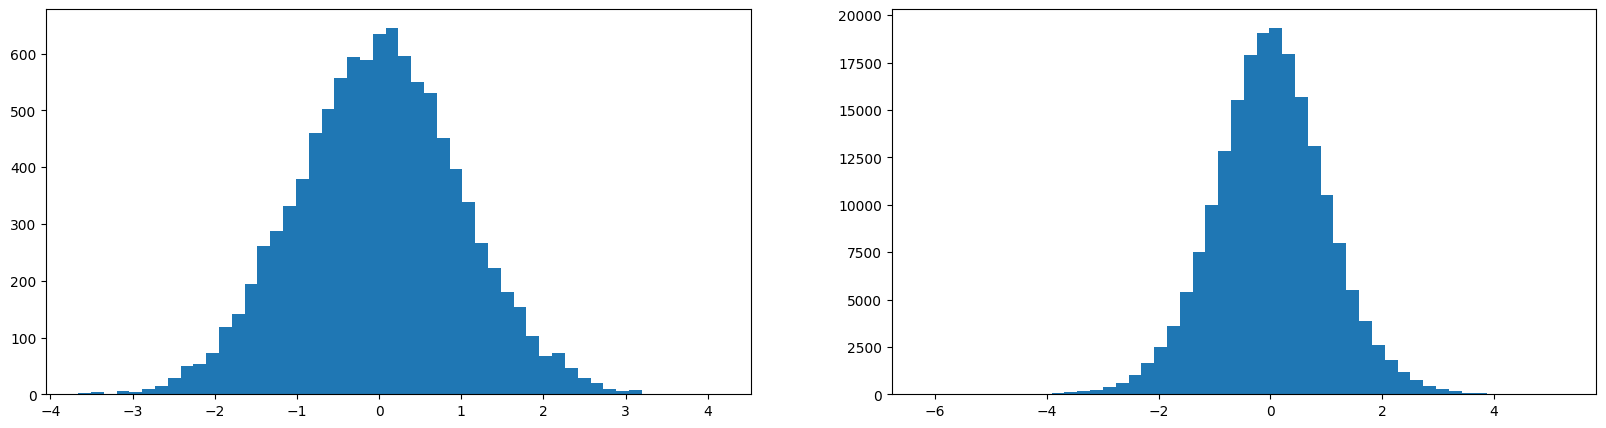

In [97]:
x = torch.randn(1000, 10)
# Математический правильный делитель чтобы оставить STD произведения в нужном диапазоне
w = torch.randn(10, 200) / 10**0.5

y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), bins=50)
plt.subplot(1, 2, 2)
plt.hist(y.view(-1).tolist(), bins=50)

Инициализация весов через torch

In [99]:
_ = torch.nn.init.kaiming_normal_(torch.empty((100, 200), dtype=torch.float),
                                  mode='fan_in',
                                  nonlinearity='tanh')

(array([2.000e+00, 0.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 6.000e+00,
        7.000e+00, 1.500e+01, 2.300e+01, 5.300e+01, 7.100e+01, 9.800e+01,
        1.560e+02, 1.870e+02, 2.880e+02, 3.370e+02, 4.580e+02, 5.560e+02,
        7.410e+02, 8.030e+02, 9.720e+02, 1.011e+03, 1.232e+03, 1.353e+03,
        1.279e+03, 1.300e+03, 1.288e+03, 1.168e+03, 1.162e+03, 1.058e+03,
        8.850e+02, 7.880e+02, 6.370e+02, 5.090e+02, 4.230e+02, 3.260e+02,
        2.230e+02, 2.020e+02, 1.280e+02, 8.000e+01, 5.900e+01, 3.800e+01,
        2.800e+01, 1.200e+01, 1.400e+01, 7.000e+00, 5.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00]),
 array([-0.41497022, -0.39861722, -0.38226423, -0.36591124, -0.34955824,
        -0.33320525, -0.31685225, -0.30049926, -0.28414626, -0.26779327,
        -0.25144027, -0.23508728, -0.21873429, -0.20238129, -0.1860283 ,
        -0.1696753 , -0.15332231, -0.13696931, -0.12061632, -0.10426332,
        -0.08791033, -0.07155734, -0.05520434, -0.03885135, -0.02249835,
        -0.

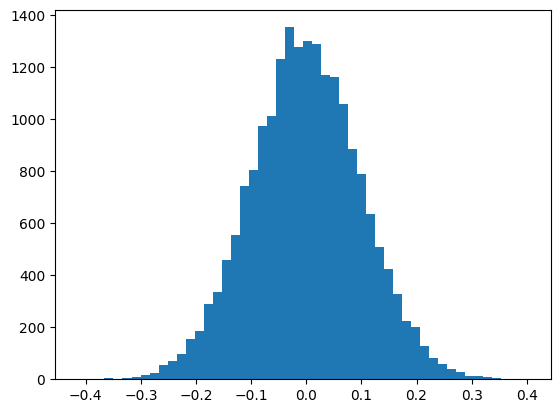

In [100]:
plt.hist(_.view(-1).tolist(), bins=50)

In [104]:
torch.randn(10000).std()

tensor(0.9956)

In [105]:
torch.randn(10000).std() * 0.2

tensor(0.2008)

In [112]:
# gain для tanh 5/3, вход 30
(5 / 3) / (30 **0.5)

0.3042903097250923

In [113]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3 / (n_embd * block_size) ** 0.5)

b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


      0/ 200000: 3.3058
  10000/ 200000: 2.2233
  20000/ 200000: 2.0154
  30000/ 200000: 2.1621
  40000/ 200000: 2.0870
  50000/ 200000: 2.1365
  60000/ 200000: 1.9862
  70000/ 200000: 2.0690
  80000/ 200000: 2.3355
  90000/ 200000: 2.4270
 100000/ 200000: 1.9816
 110000/ 200000: 1.7904
 120000/ 200000: 2.0591
 130000/ 200000: 2.2953
 140000/ 200000: 1.7582
 150000/ 200000: 1.9688
 160000/ 200000: 1.7966
 170000/ 200000: 1.8803
 180000/ 200000: 1.6804
 190000/ 200000: 2.1836


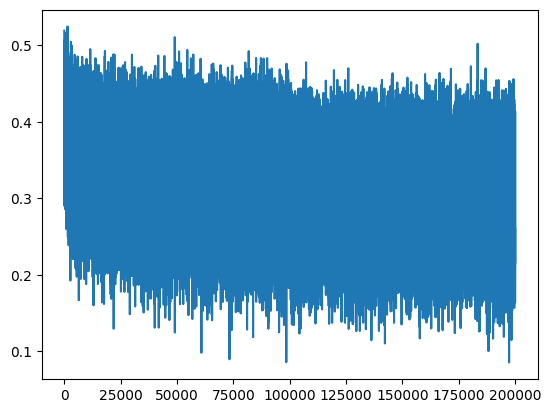

In [115]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activatio
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
  # break
plt.plot(lossi)

In [116]:
split_loss('train')
split_loss('val')

train 2.0353357791900635
val 2.1057934761047363


# BatchNorm

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3 / (n_embd * block_size) ** 0.5)

b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [121]:
# 200 колонок - 200 нейронов

hpreact

tensor([[-2.3423, -0.9169,  0.2829,  ..., -0.5286, -3.2816,  1.8116],
        [-3.4734,  0.6989, -3.7892,  ...,  1.9184, -3.5973,  4.2713],
        [ 0.6515,  2.5613,  2.0009,  ...,  3.9769, -0.9652,  1.6980],
        ...,
        [ 2.3241,  3.7516, -1.5839,  ..., -2.5440, -0.8266,  2.8113],
        [-0.1103,  1.0852, -1.0351,  ..., -0.7996,  1.4676,  1.1643],
        [-0.2778, -1.6861, -0.7255,  ..., -6.0433,  2.7076, -0.2348]],
       grad_fn=<AddBackward0>)

In [117]:
hpreact.shape

torch.Size([32, 200])

In [119]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [120]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [125]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3 / (n_embd * block_size) ** 0.5)

b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


      0/ 200000: 3.3200
  10000/ 200000: 2.2652
  20000/ 200000: 2.0890
  30000/ 200000: 2.1251
  40000/ 200000: 2.3199
  50000/ 200000: 2.0850
  60000/ 200000: 2.0431
  70000/ 200000: 2.0884
  80000/ 200000: 2.3345
  90000/ 200000: 2.2917
 100000/ 200000: 1.9389
 110000/ 200000: 1.8129
 120000/ 200000: 2.1642
 130000/ 200000: 2.3530
 140000/ 200000: 1.8103
 150000/ 200000: 1.9819
 160000/ 200000: 1.9102
 170000/ 200000: 2.0019
 180000/ 200000: 1.7223
 190000/ 200000: 2.3048


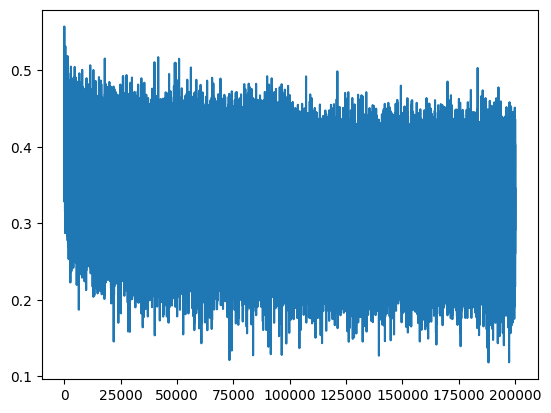

In [126]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activations


    # BatchNorm
    # Стандартизация и нормализация
    hpreact = hpreact - hpreact.mean(0, keepdim=True)
    hpreact = hpreact / hpreact.std(0, keepdim=True)

    # Изменение масштаба, обучаемые параметры сети
    hpreact = hpreact * bngain + bnbias



    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
  # break
plt.plot(lossi)

In [127]:
# Добавил BatchNorm к верификации
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtr, Ytr),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1

        # BatchNorm
    # Стандартизация и нормализация
    hpreact = hpreact - hpreact.mean(0, keepdim=True)
    hpreact = hpreact / hpreact.std(0, keepdim=True)

    # Изменение масштаба, обучаемые параметры сети
    hpreact = hpreact * bngain + bnbias

    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.067362070083618
val 2.111328125


Для семплирования из сетки с применением BatchNorm недобходимо зафиксировать единые средние значения bnmean и bnstd, и затем применять их в ходе семплирования

In [135]:
with torch.no_grad():
    # Берем весь training set, получаем эмбеддинги для него
    emb = C[Xtr]
    # Разворачиваем в 2д матрицу
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1

    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [136]:
C.shape

torch.Size([27, 10])

In [137]:
Xtr.shape

torch.Size([182570, 3])

In [138]:
C[Xtr].shape

torch.Size([182570, 3, 10])

Что делает C[Xtr]

PyTorch интерпретирует Xtr как набор индексов по первой оси C.

То есть:

Каждый элемент Xtr[i, j] используется как индекс строки в C

Типичный сценарий использования

Чаще всего это используется как embedding lookup:

	•	C — embedding-матрица
	•	Xtr — последовательности токенов / символов
	•	C[Xtr] — embedding-представление входных данных

In [139]:
emb.view(emb.shape[0], -1)

tensor([[ 1.3994,  0.1058, -0.1310,  ...,  0.2751, -0.5496,  0.0027],
        [ 1.3994,  0.1058, -0.1310,  ...,  0.9587, -0.8803, -1.5511],
        [ 1.3994,  0.1058, -0.1310,  ..., -0.2950,  0.9069, -0.0231],
        ...,
        [ 0.0142,  0.9945, -0.3449,  ..., -0.7327,  0.2984, -1.1331],
        [-0.3867, -0.3965, -1.0495,  ...,  0.4745,  0.4818, -1.8103],
        [ 0.0142,  0.9945, -0.3449,  ..., -1.2073, -1.6434, -1.3879]])

In [140]:
# Добавил BatchNorm к верификации
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtr, Ytr),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1

    # BatchNorm
    # Стандартизация и нормализация, с использованием средних значений по всему training set
    hpreact = hpreact - bnmean
    hpreact = hpreact / bnstd
    # Изменение масштаба, обучаемые параметры сети
    hpreact = hpreact * bngain + bnbias

    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.067362070083618
val 2.1112942695617676


Вместо оценки mean и std в конце обычно в циклы обучения просто добавляется скользящая оценка по ходу дела

In [146]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3 / (n_embd * block_size) ** 0.5)

b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# Контроль смещения и разброса статистики BN слоя
bngain = torch.ones((1, n_hidden)) # scale
bnbias = torch.zeros((1, n_hidden)) # shift

# Не оптимизируются в процессе обучения, просто обновляются как переменные
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


      0/ 200000: 3.3065
  10000/ 200000: 2.3215
  20000/ 200000: 2.0957
  30000/ 200000: 2.1403
  40000/ 200000: 2.2473
  50000/ 200000: 2.2354
  60000/ 200000: 2.1409
  70000/ 200000: 2.0911
  80000/ 200000: 2.2552
  90000/ 200000: 2.3679
 100000/ 200000: 1.7994
 110000/ 200000: 1.8597
 120000/ 200000: 2.1080
 130000/ 200000: 2.3450
 140000/ 200000: 1.7899
 150000/ 200000: 2.0386
 160000/ 200000: 1.9375
 170000/ 200000: 1.9142
 180000/ 200000: 1.7267
 190000/ 200000: 2.2517


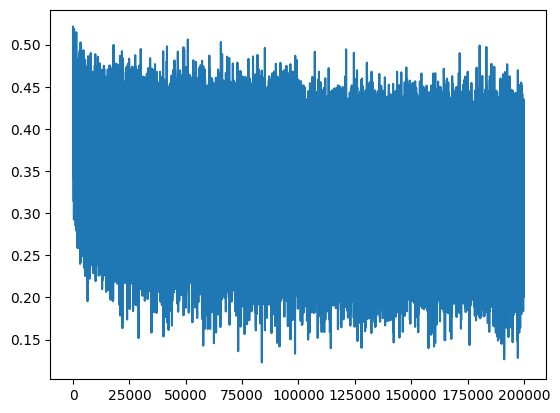

In [147]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activations


    # BatchNorm
    # Стандартизация и нормализация

    # Оценка среднего и стд по ходу дела
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)

    hpreact = hpreact - hpreact.mean(0, keepdim=True)
    hpreact = hpreact / hpreact.std(0, keepdim=True)

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd




    # Изменение масштаба, обучаемые параметры сети
    hpreact = hpreact * bngain + bnbias



    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
  # break
plt.plot(lossi)

In [151]:
with torch.no_grad():
    # Берем весь training set, получаем эмбеддинги для него
    emb = C[Xtr]
    # Разворачиваем в 2д матрицу
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1

    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

Видно, что оценки если посчитать статистику отдельно, и скользящим окном близки, поэтому можно использовать скользящее окно, в BN pytorch так и сделано

In [152]:
print(bnmean)

tensor([[-2.1580,  0.6479, -1.0067,  0.8812,  0.6645,  1.1356,  2.6082, -2.1723,
          0.9236,  1.0973, -1.6970, -2.6179, -0.2099, -0.1833,  0.3107,  0.2315,
          0.5466, -3.0315, -1.0637,  0.8032, -0.7544,  0.1613, -0.5935,  0.3172,
          1.4169,  1.3623,  1.2576, -0.3517,  1.1298,  1.3525, -0.5403, -1.2804,
          0.3408,  0.0651, -0.9249, -1.4654,  0.0417, -0.0300, -0.2776,  0.3625,
         -0.3066, -1.6821, -0.2004,  0.0865,  0.6497, -0.4826,  1.9372, -1.3304,
          2.5928,  1.1924,  1.2440,  0.0374,  2.0286,  1.2406,  1.0491, -2.8229,
         -0.4457,  0.4038,  1.6601, -1.7407, -1.3611,  1.1488,  0.0058,  0.3702,
          1.5199,  1.1742,  0.0887,  1.7033, -0.9535, -0.1650,  0.1737,  0.6569,
          0.7780, -1.4484, -2.3963,  0.6214,  1.4147, -1.0440,  0.8510,  0.4487,
          0.6089,  1.4772,  1.5964, -0.2184, -0.2879, -0.6018, -0.5736,  0.2264,
          2.4421, -0.3679, -1.2975,  0.6855, -1.4328, -1.6087, -0.8314,  0.8456,
          0.3859, -0.6675, -

In [153]:
print(bnmean_running)

tensor([[-2.1731,  0.6354, -0.9968,  0.8598,  0.6621,  1.1488,  2.6038, -2.1604,
          0.9062,  1.0870, -1.6978, -2.6024, -0.2110, -0.1937,  0.2988,  0.2082,
          0.5342, -3.0317, -1.0575,  0.8034, -0.7465,  0.1435, -0.5967,  0.3144,
          1.4304,  1.3421,  1.2414, -0.3590,  1.1354,  1.3397, -0.5515, -1.2723,
          0.3263,  0.0576, -0.9326, -1.4571,  0.0444, -0.0304, -0.2828,  0.3447,
         -0.3078, -1.6988, -0.2080,  0.0708,  0.6503, -0.4707,  1.9220, -1.3329,
          2.5958,  1.1948,  1.2462,  0.0450,  2.0253,  1.2234,  1.0471, -2.8046,
         -0.4498,  0.4429,  1.6632, -1.7289, -1.3574,  1.1470,  0.0035,  0.3662,
          1.5194,  1.1648,  0.0907,  1.6972, -0.9518, -0.1708,  0.1529,  0.6695,
          0.7734, -1.4409, -2.4143,  0.6270,  1.4129, -1.0527,  0.8284,  0.4522,
          0.5960,  1.4748,  1.5839, -0.2101, -0.3062, -0.5979, -0.5514,  0.2372,
          2.4445, -0.3645, -1.2861,  0.6758, -1.4234, -1.6188, -0.8414,  0.8272,
          0.3695, -0.6749, -

Оценка с использованием running оценки среднего и std

In [154]:
# Добавил BatchNorm к верификации
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtr, Ytr),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1

    # BatchNorm
    # Стандартизация и нормализация, с использованием средних значений по всему training set
    hpreact = hpreact - bnmeani
    # Для математической стабильности, чтобы избежать деления на 0 при std равном идеально 0
    epsilon = 1e-5
    hpreact = hpreact / (bnstdi + epsilon)
    # Изменение масштаба, обучаемые параметры сети
    hpreact = hpreact * bngain + bnbias

    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0846505165100098
val 2.122255802154541


Как видно, b почти равен нулю, тк мы при добавлении BN постоянно смещаем среднее к 0, а поэтому каждый раз избавляемся от эффекта смещения. Поэтому при использовании BN bias опускается. Теперь bias от BN отвечает за этот смысл

In [158]:
b1.grad.mean()

tensor(-1.3002e-10)

In [159]:
b1.grad.sum()

tensor(-2.6004e-08)

In [156]:
epsilon = 1e-5
epsilon

1e-05

### Переписанный чистовой вариант bn

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3 / (n_embd * block_size) ** 0.5)

# b1 = torch.randn(n_hidden,                        generator=g) * 0.01 ТК для этого слоя используется BN
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0


# Параметры BatchNorm
bngain = torch.ones((1, n_hidden)) # scale
bnbias = torch.zeros((1, n_hidden)) # shift
# Не оптимизируются в процессе обучения, просто обновляются как переменные
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [160]:
max_stems = 200_000
batch_size = 256
lossi = []

for i in range(max_steps):
    # Индексы батча
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)

    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb] # Кодирую символы как эмбеддинги
    embcat = emb.view(emb.shape[0], -1) # Разворачиваю эмбеддинги в вектора

    # Linear Layer
    hpreact = embcat @ W1 # + b1 hidden layer pre-activation

    # BatchNorm layer
    # ------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)

    hpreact = bngain * (hpreact - bnmeani) / (bnstdi + 1e-5) + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnmeani
    # ------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2
    # torch.nn.functional.cross_entropy — это комбинация двух операций:
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in parameters:
        p.grad = None
    # Рассчитываем и записываем градиенты для параметров
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    # Берется тензор с параметрами, и сразу обновляется весь, .data нужно для доступа к содержимому
    for p in parameters:
        p.data += - lr * p.grad

    if i % 10_000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

На примере ResNet было рассказано понятие BottleNeck block - Когда сетка состоит из пачки повторяющихся "типовых" блоков, напимер Conv + BN + Relu, и эта конструкция повторяется.

Мы тут примерно это и написали